<a href="https://colab.research.google.com/github/Eylz-Liu/Mod-le-vol-locale/blob/main/Etude_local_vol_complet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volatilité locale (Dupire) : calibration et Monte Carlo
---


> **Antonin Chaix**


Le but de ce TP est de d'implémenter un modèle à volatilité locale à partir d'une surface de vol implicite de marché donnée par le modèle SABR (term structure de paramètres SABR interpolée en temps par des splines cubiques).

## Le modèle

Le modèle est donné par l'EDS suivante, sous la mesure risque-neutre :

$$
\frac{dS_t}{S_t}=\mu(t)dt+\sigma(t,S_t)dW_t
$$

où le drift déterministe $\mu(t)$  est inféré à partir de la term-structure des forwards sur l'actif $S$ (considérée comme un input). Ainsi, la fonction $\mu$ constante par morceaux pourra être déterminée grâce à la relation suivante :

$$
F_0(T) = S_0\exp\left(\int_0^T \mu(s)ds\right)
$$

où $F_0(T)$ représente à l'instant $t=0$ le forward de maturité $T$ sur l'actif $S$.

La formule de Dupire nous donne explicitement la fonction de volatilité locale $\sigma$ à partir de la nappe de volatilité implicite $\hat\sigma$, dès lors que celle-ci est suffisamment régulière (continuement dérivable une fois par rapport $T$ et deux fois par rapport à $K$). C'est ce qui fait la force et le succès du modèle à volatilité locale : dès lors que l'on a créé par interpolation une belle nappe de volatilité implicite, on connaît explicitement la volatilité locale $\sigma$ qui calibre le modèle sur ces volatilités implicites.

La formule de Dupire donnant la vol locale $\sigma$ en fonction de la vol implicite $\hat\sigma$ est la suivante :

$$
\sigma^2(T,K)=\frac{2\frac{\partial \hat\sigma}{\partial T}+\frac{\hat\sigma}{T}+2K\mu(T)\frac{\partial \hat\sigma}{\partial K}}
{K^2\left[\frac{\partial^2 \hat\sigma}{\partial K^2}-d_1\sqrt{T}\left(\frac{\partial \hat\sigma}{\partial K}\right)^2+\frac{1}{\hat\sigma
}\left(\frac{1}{K\sqrt{T}}+d_1\frac{\partial \hat\sigma}{\partial K}\right)^2\right]}\\
$$
avec
$$
d_1=\frac{\ln(S_0/K)+\int_0^T\mu(s)ds}{\hat\sigma\sqrt{T}}
+ \frac{1}{2}\hat\sigma\sqrt{T}
$$

<br>**NB** : bien noter le caractère muet des variables $T$ et $K$ (ou plus exactement la dualité entre les variables $(T,K)$ et $(t,S_t)$). Concrétement, pour calculer la volatilité locale au point $(t, S_t)$ (dans un Monte Carlo par exemple), on évaluera donc :

$$
\sigma^2(t,S_t)=\frac{2\frac{\partial \hat\sigma}{\partial T}(t,S_t)+\frac{\hat\sigma(t,S_t)}{t}+2S_t\mu(t)\frac{\partial \hat\sigma}{\partial K}(t,S_t)}
{S_t^2\left[\frac{\partial^2 \hat\sigma}{\partial K^2}(t,S_t)-d_1\sqrt{t}\left(\frac{\partial \hat\sigma}{\partial K}(t,S_t)\right)^2+\frac{1}{\hat\sigma(t,S_t)
}\left(\frac{1}{S_t\sqrt{t}}+d_1\frac{\partial \hat\sigma}{\partial K}(t,S_t)\right)^2\right]}\\
$$
avec
$$
d_1=\frac{\ln(S_0/S_t)+\int_0^t\mu(s)ds}{\hat\sigma(t,S_t)\sqrt{t}}
+ \frac{1}{2}\hat\sigma(t,S_t)\sqrt{t}
$$


## La courbe des taux

On se donne la courbe zéro-coupon en interpolant ses piliers avec des splines cubiques et on définit quelques fonctions utiles pour la suite...

In [24]:
import numpy as np
import math
from scipy.interpolate import interp1d

# yield curve (zero rates)
yc_maturities = np.array([0, 1, 2, 5, 10, 15, 20, 30])
yc_zc_rates = np.array([-0.55, -0.52, -0.51, -0.4,  -0.18,  0.02,  0.11,  0.09]) * 0.01
yc_zc_rates_interp = interp1d(yc_maturities, yc_zc_rates, kind='cubic', fill_value="extrapolate")

def zc_rate(T) :
    return yc_zc_rates_interp(T)

def DF(T) :
    return math.exp(-yc_zc_rates_interp(T)*T)

Voyons voir à quoi ressemble notre courbe ZC :


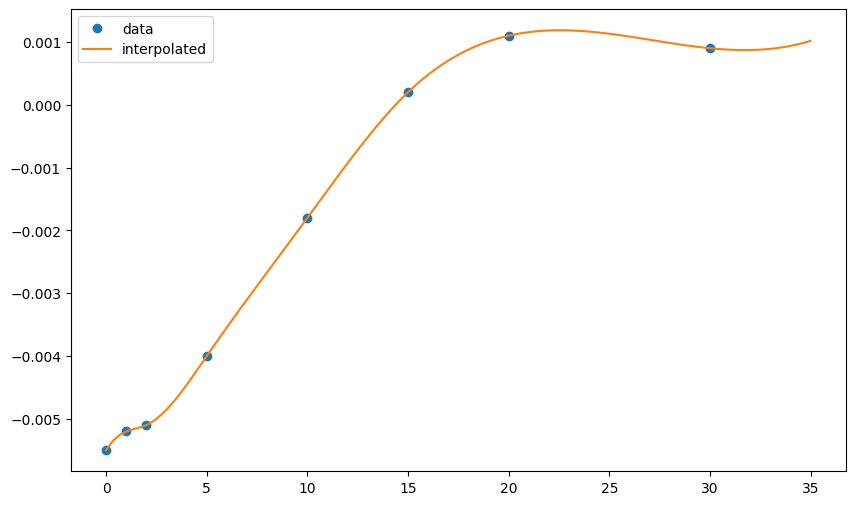

In [25]:
# plot zc curve
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
maturities = np.linspace(0, 35, num=101, endpoint=True)
plt.plot(yc_maturities, yc_zc_rates, 'o', maturities, zc_rate(maturities))
plt.legend(['data', 'interpolated'], loc='best')
plt.show()

## Le sous-jacent

On définit ici les term-structures :

* des forwards
* des paramètres SABR permettant de construire la nappe de vol

<br>

**Disclaimer :** *ceci est un colab pédagogique, nous utilisons par commodité une nappe de volatilité implicite générée au moyen d'une term structure de paramètres SABR, mais ce n'est en aucun cas un standard de marché sur les actions.*

In [26]:
# underlying params
S0 = 100
S_maturities = np.array([0.08, 0.25, 0.50, 1.00, 1.50, 2.00])
S_forwards = np.array([99.9563, 99.8655, 99.7354, 99.4813, 99.2301, 98.9851])  # généré sans dividendes avec s_forwards = S0 * np.exp(zc_rate(s_maturities)*s_maturities)
S_sigma0 = np.array([20.0, 18.5, 17.4, 16.5, 15.5, 14.5]) * 0.01
S_alpha = np.array([95, 80, 70, 60, 50, 40]) * 0.01
S_rho = np.array([-0.4, -0.35, -0.3, -0.3, -0.3, -0.3])
S_beta = np.full(6, 1.)

# implied vol : cubic spline interp on sabr params
S_forwards_interp = interp1d(S_maturities, S_forwards, kind='cubic', fill_value="extrapolate")
S_sigma0_interp = interp1d(S_maturities, S_sigma0, kind='cubic', fill_value="extrapolate")
S_alpha_interp = interp1d(S_maturities, S_alpha, kind='cubic', fill_value="extrapolate")
S_rho_interp = interp1d(S_maturities, S_rho, kind='cubic', fill_value="extrapolate")
S_beta_interp = interp1d(S_maturities, S_beta, kind='cubic', fill_value="extrapolate")

Il nous faut bien sûr la fonction SABR pour travailler...

In [27]:
# SABR lognormal vol formula from [https://github.com/ynouri/pysabr] made numpy compatible
def sabr_vol (T, K, F0, sigma0, alpha, rho, beta) :
    """
    Hagan's 2002 SABR lognormal vol expansion.
    The strike K can be a scalar or an array, the function will return an array
    of lognormal vols.
    """
    eps = 1e-07
    logfk = np.log(F0 / K)
    fkbeta = (F0*K)**(1 - beta)
    a = (1 - beta)**2 * sigma0**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * alpha * sigma0 / fkbeta**0.5
    c = (2 - 3*rho**2) * alpha**2 / 24
    d = fkbeta**0.5
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920
    z = alpha * fkbeta**0.5 * logfk / sigma0
    tmp = sigma0 * (1 + (a + b + c) * T)
    num = np.where(abs(z) > eps, z * tmp, tmp)
    den = np.where(abs(z) > eps, (d * (1 + v + w) * _x(rho, z)), d * (1 + v + w))
    return num / den

def _x(rho, z):
    """Return function x used in Hagan's 2002 SABR lognormal vol expansion."""
    a = (1 - 2*rho*z + z**2)**.5 + z - rho
    b = 1 - rho
    return np.log(a / b)


Ce qui permet de definir notre nappe de volatilité implicite, puis la fonction calculant la volatilité locale à partir de la vol implicite :

In [28]:
# implied vol : time dependent spline interpolation of SABR parameters
def implied_vol(T, K) :
	F0 = S_forwards_interp(T)
	sigma0 = S_sigma0_interp(T)
	alpha = S_alpha_interp(T)
	rho = S_rho_interp(T)
	beta = S_beta_interp(T)
	return sabr_vol(T, K, F0, sigma0, alpha, rho, beta)

# local vol from Dupire's formula
def local_vol(t, S) :
    t = np.where(t == 0, 1e-08, t) # to avoid divide by 0
    eps_t = 1e-07
    eps_S = eps_t * S
    vol = implied_vol(t, S)
    sqrt_t = np.sqrt(t)
    drift = np.log(S_forwards_interp(t + eps_t) / S_forwards_interp(t)) / eps_t
    dvol_dT = (implied_vol(t + eps_t, S) - vol) / eps_t
    vol_plus  = implied_vol(t, S + eps_S)
    vol_minus = implied_vol(t, S - eps_S)
    dvol_dK = (vol_plus - vol) / eps_S
    d2vol_dK2 = (vol_plus + vol_minus  - 2 * vol) / eps_S**2
    d1 = (np.log(S0 / S) + np.log(S_forwards_interp(t) / S0) + 0.5 * vol**2 * t) / (vol * sqrt_t)
    num = 2 * dvol_dT + vol / t + 2 * S * drift * dvol_dK
    den = S**2 * (d2vol_dK2 - d1*sqrt_t*dvol_dK**2 + (1/(S*sqrt_t) + d1*dvol_dK)**2 / vol)
    return np.sqrt(np.where(num/den >= 0, num/den, 0))


Voyons voir à quoi ressemble notre vol implicite et notre vol locale...

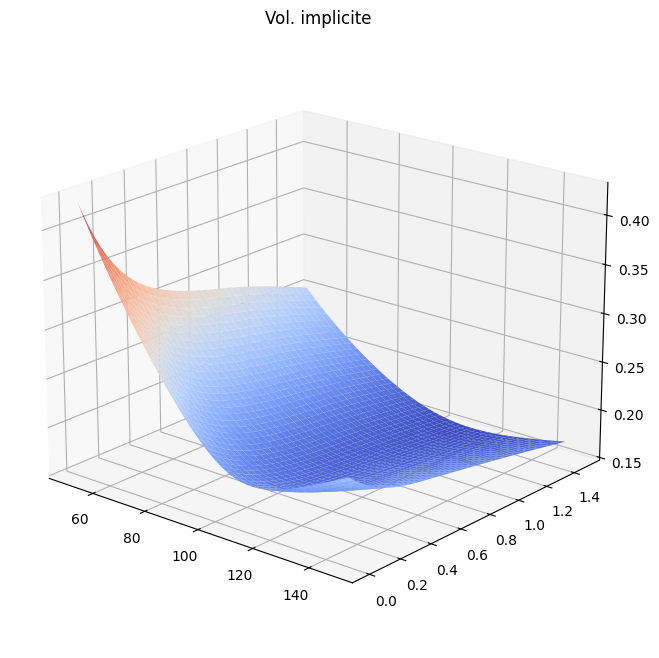

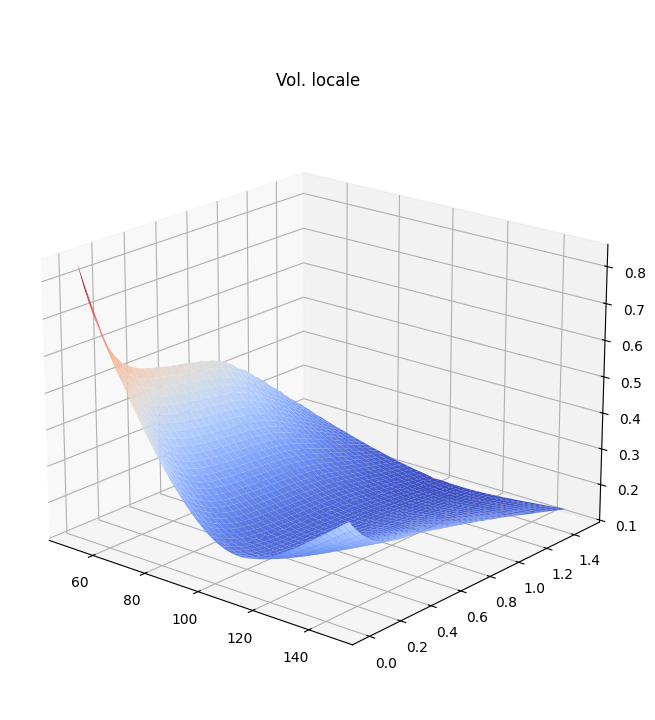

In [29]:
# plot implied vol or local vol surface
from matplotlib import cm
plt.rcParams["figure.figsize"] = (11,8)

K = np.arange(50, 150, 2)
T = np.arange(0, 1.5, 0.02)
K, T = np.meshgrid(K, T)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
vols = implied_vol(T, K) # vols = local_vol(T, K)
surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.view_init(elev=20, azim=-50)  # pour changer l'angle de vue
plt.title("Vol. implicite")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
vols = local_vol(T, K)
surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.view_init(elev=20, azim=-50)  # pour changer l'angle de vue
plt.title("\n\n\nVol. locale")
plt.show()

## Monte Carlo

L'objectif est d'implémenter un Monte Carlo dans le modèle à vol locale afin :

* de vérifier si les prix obtenus pour des options européennes sont conformes à ceux fournis par la nappe de vol implicite en input
* de pricer une option binaire européenne et de vérifier si le prix obtenu est conforme au pricing par call spread (utilisant les vols implicites)
* de pricer un call barrière up & in



**NB** : dans [ce colab](https://colab.research.google.com/drive/190FfBc0w-fz8vim3x7RrFcb_Tu-Px2Hu?usp=sharing), vous trouverez l'implémentation du schéma de différences finies dans le même modèle à volatilité locale. Dès que cela est possible (option pas "trop" path-dependent), cette solution est à privilégier par rapport au Monte Carlo (temps de calcul beaucoup plus faible, et résultats plus précis !)

### Simulation des trajectoires de l'actif

In [30]:
# MC params
T = 1 # horizon de simulation = maturité des options
Nsimul = 10**6
Nsteps = 100

# generate random N(0,1)
normal = np.random.normal(0, 1, (Nsteps, Nsimul))

# time vector
dt = T / Nsteps
t = np.linspace(0, T, num=Nsteps+1, endpoint=True)
sqrt_dt = math.sqrt(dt)

# S array (time x simulations)
S = np.empty(shape=(Nsteps + 1, Nsimul))
S[0,:] = S0

# local vol interpolation params
n_interp = 101
n_stdev = 5
prev_fwd = S0

for j in range(Nsteps) :

	# S points for local vol interpolation computed for each time step (from standard deviation of S)
    fwd = S_forwards_interp(t[j+1])
    vol = implied_vol(t[j+1], fwd)
    Smax = fwd * math.exp(-0.5 * vol**2 * t[j+1] + n_stdev * vol * math.sqrt(t[j+1]))
    Smin = fwd * math.exp(-0.5 * vol**2 * t[j+1] - n_stdev * vol * math.sqrt(t[j+1]))
    Sinterp = np.linspace(Smin, Smax, num=n_interp, endpoint=True)

	# compute local vol interpolation
    local_vol_interp = interp1d(Sinterp, local_vol(t[j], Sinterp), kind='cubic', fill_value="extrapolate")

	# vol & drift
    sigma = local_vol_interp(S[j,:]) # interpolation is much faster than sigma = local_vol(t[j], S[j,:])

    mu = math.log(fwd / prev_fwd) / dt
    prev_fwd = fwd

    # main loop on simulations
    S[j+1,:] = S[j,:] * np.exp( (mu - 0.5 * sigma**2) * dt + sigma * sqrt_dt * normal[j,:])

In [31]:
# Une petite fonction pour calculer le prix Monte Carlo à partir du payoff et afficher l'intervalle de confiance
def compute_and_print_price(payoff, option_name, closed_form_price = -1) :
	price = np.mean(payoff)
	stdev = np.std(payoff)
	IClow = price - 1.96 * stdev / math.sqrt(Nsimul)
	ICup = price + 1.96 * stdev / math.sqrt(Nsimul)
	if (closed_form_price == -1) : print("{} = {:.4f}".format(option_name, price) )
	else : 	print("{} = {:.4f} (closed-form price = {:.4f})".format(option_name, price, closed_form_price) )
	print("IC 95% = [{:.4f} ; {:.4f}]".format(IClow,ICup) )
	print("-----------------------------------------------------")


### Repricing d'un call européen

On vérifie que le prix obtenu dans le Monte Carlo du modèle à vol locale pour un call européen coïncide avec Black-Scholes @ vol implicite...

In [32]:
from scipy.stats import norm

# BS call function
def bs_call(T, K, F0, sigma) :
	sigma_sqrt_T = sigma * math.sqrt(T)
	d1 = (math.log(F0/K) + 0.5 * sigma**2 * T) / sigma_sqrt_T
	d2 = d1 - sigma_sqrt_T
	return F0 * norm.cdf(d1) - K * norm.cdf(d2)

# call strike
K = 100

# european call payoff
payoff_call_eur = DF(T) * np.maximum(S[-1,:] - K , 0)

# closed form for european call
vol = implied_vol(T, K)
fwd = S_forwards_interp(T)
call_eur =  DF(T) * bs_call(T, K, fwd, vol)

# Pricing du call européen dans le modèle à vol locale
compute_and_print_price(payoff_call_eur, "Call européen", call_eur)


Call européen = 6.4274 (closed-form price = 6.4379)
IC 95% = [6.4069 ; 6.4480]
-----------------------------------------------------


### Pricing d'une binaire européenne

On évalue une option digitale dans le modèle à vol locale et on vérifie que l'on retombe sur le prix obtenu par call spread à partir de la nappe de vol implicite.

In [33]:
# digital strike - options pays 1 if S(T) > K and 0 otherwise
K = 100

# digital payoff
payoff_binaire = DF(T) * np.where(S[-1,:] > K, 1., 0.)

# closed form for digital option (call spread)
fwd = S_forwards_interp(T)
vol_minus = implied_vol(T, K-1)
vol_plus  = implied_vol(T, K+1)
digital = DF(T) * (bs_call(T, K-1, fwd, vol_minus) - bs_call(T, K+1, fwd, vol_plus)) / 2.

# "naïve" black-scholes price (no skew)
vol = implied_vol(T, K)
digital_bs = DF(T) * (bs_call(T, K-1, fwd, vol) - bs_call(T, K+1, fwd, vol)) / 2.

# compute & display
compute_and_print_price(payoff_binaire, "Binaire", digital)
print("Binaire BS naïve = {:.4f}".format(digital_bs))

Binaire = 0.4919 (closed-form price = 0.4918)
IC 95% = [0.4909 ; 0.4929]
-----------------------------------------------------
Binaire BS naïve = 0.4567


### Pricing d'un call barrière up & in : vol locale vs. BS

On évalue un call up & in dont le payoff est :

$$
(S_T-K)^+\mathbb{1}_{\{\max_{[0,T]}S_t > H\}}
$$

La différence de prix entre vol locale et Black & Scholes n'est pas négligeable. Elle s'explique par la présence d'un risque digital au niveau de la barrière H = 120 déclenchant le paiement de l'option. A cet endroit, et tout au long de la vie de l'option, le smile est pentu (en l'occurence croissant), impliquant une différence d'évaluation du risque digital entre BS (pas de smile) et la vol locale (qui intégre cette pente sur la vol implicite).

# Scénario 1 - Simulation d'un mini Dupire


Dans le cadre d'introduction de Modèle à volatilité locale via la formule de Dupire, voici un petite exemple avec une surface de volatilité implicite récupéré sur bloomberg concernant Eurostexx 50 (SXE5)

'Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50' (%):
          80%   90%   95%  100%  105%  110%  120%
0.08 an  36.2  24.0  18.7  14.4  12.1  13.2  20.4
0.25 an  27.8  21.0  18.1  15.6  13.9  13.1  13.8
0.50 an  24.9  20.0  17.7  15.9  14.6  13.8  13.2
1.00 an  22.9  19.5  18.0  16.7  16.1  15.7  14.9
2.00 an  21.6  19.3  18.3  17.4  16.7  16.0  14.9


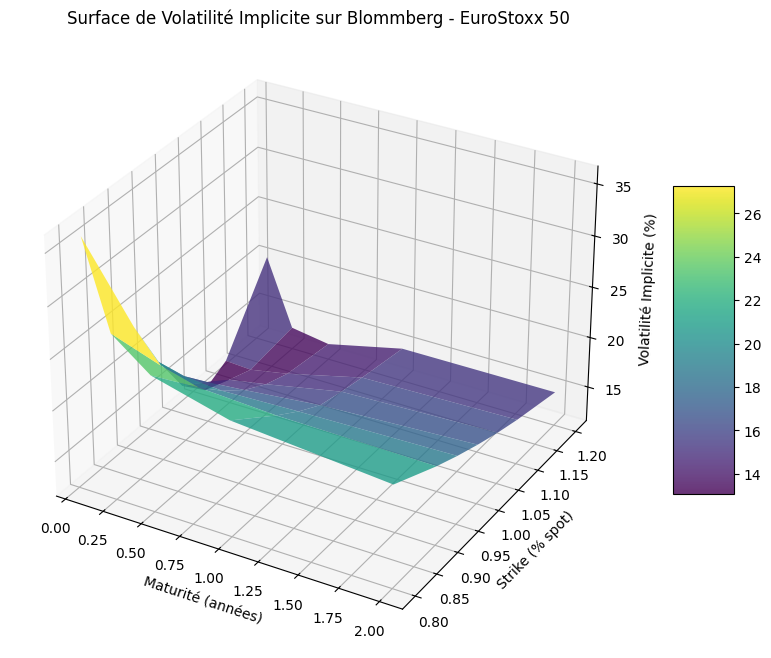

In [34]:
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
# ************ 1. collecte des données   ***************************
T = np.array ( [0.08, 0.25, 0.5, 1.0, 2.0 ] )  # Maturité en année
K = np.array ((0.8, 0.9,0.95, 1.0,1.05, 1.1, 1.2 ) )     # spot price
spot_price = 5655     # Prix spot fictif de l'EuroStoxx 50

# Grille de maturités (en années)
maturities = np.array([0.08, 0.25, 0.5, 1.0, 2.0])

# Grille de strikes (en % du spot)
strike_ratios = np.array([0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2])
strikes = strike_ratios * spot_price

# Surface de volatilité implicite fictive (en %) # Dimensions: 5 maturités × 7 strikes
iv_matrix = np.array([
    # 80%    90%    95%    100%    105%    110%    120%  (strike ratios)
    [36.19, 24.03, 18.72,  14.41,  12.07,  13.24,  20.37],  # 1 mois (0.08 an) 5/12/2025
    [27.79, 21.00, 18.06,  15.58,  13.92,  13.08,  13.76],  # 3 mois (0.25 an) 20/02/2026
    [24.91, 19.95, 17.74,  15.91,  14.60,  13.79,  13.15],  # 6 mois (0.5 an)  15/05/2026
    [22.91, 19.52, 17.98,  16.68,  16.13,  15.66,  14.89],  # 1 an (1.0 an)    20/11/2026
    [21.59, 19.31, 18.32,  17.44,  16.66,  16.00,  14.93]    # 2 ans (2.0 an)   07/11/2027
])

# Surface de volatilité implicite fictive (en %) # Dimensions: 5 maturités × 7 strikes
iv_matrix2 = np.array([
    # 80%    90%    95%    100%    105%    110%    120%  (strike ratios)
    [88.94, 59.04, 36.85,  16.97,  23.49,  37.12,  53.28],  # 1 day (0.003 an)   07/11/2027
    [36.19, 24.03, 18.72,  14.41,  12.07,  13.24,  20.37],  # 1 mois (0.08 an) 5/12/2025
    [27.79, 21.00, 18.06,  15.58,  13.92,  13.08,  13.76],  # 3 mois (0.25 an) 20/02/2026
    [24.91, 19.95, 17.74,  15.91,  14.60,  13.79,  13.15],  # 6 mois (0.5 an)  15/05/2026
    [22.91, 19.52, 17.98,  16.68,  16.13,  15.66,  14.89],  # 1 an (1.0 an)    20/11/2026

])

# Création d'un DataFrame pour une meilleure visualisation
iv_df = pd.DataFrame(
    iv_matrix,
    index=[f'{m:.2f} an' for m in maturities],
    columns=[f'{ratio:.0%}' for ratio in strike_ratios]
)

print("'Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50' (%):")
print(iv_df.round(1))
# IV_surface = interpolate.rectBivaruateSoline(T,K,IV,kx=3,ky=3,s=0.1)
# IV_surface = iv_df
# print(IV_surface.round(1))

# Création de la grille
T_mesh, K_mesh = np.meshgrid(maturities, strike_ratios)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface 3D
surf = ax.plot_surface(T_mesh, K_mesh, iv_matrix.T, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)

ax.set_xlabel('Maturité (années)')
ax.set_ylabel('Strike (% spot)')
ax.set_zlabel('Volatilité Implicite (%)')
ax.set_title('Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50')

plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

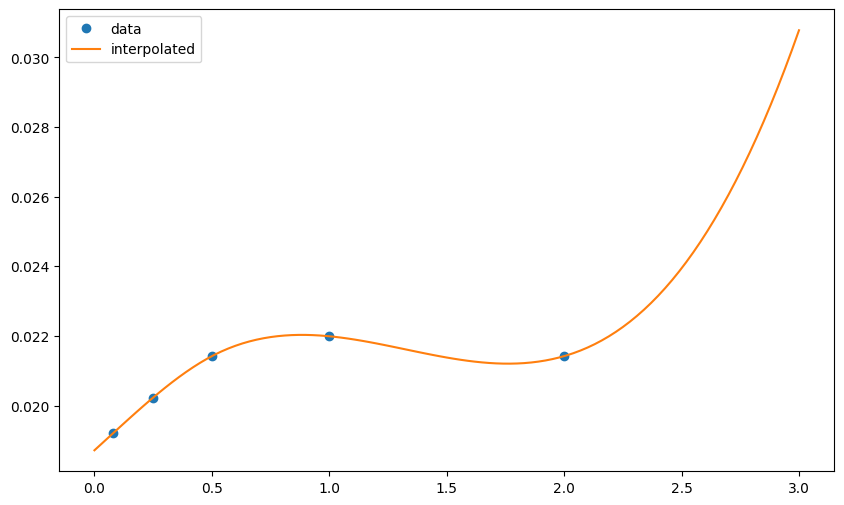

In [35]:
from scipy import interpolate

# Taux sans risque r(T):
rates_dates = np.array([0.08, 0.25, 0.5, 1.0, 2.0])  # maturités
#rates_dates = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ])

rates_values = np.array([0.01921, 0.02023, 0.02142, 0.02199, 0.02142])  # taux
rate_curve = interpolate.interp1d(rates_dates, rates_values,kind='cubic', fill_value='extrapolate')
r = rate_curve(T)

# Taux de dividende q(T):
# Méthode 1: Dividendes implicites depuis les forwards
# Méthode 2: Dividendes explicites actualisés q = 0.02

dividend_dates = np.array([0.08, 0.25, 0.5, 1.0, 2.0])  # maturités
#dividend_dates = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ])

dividend_values = np.array([0.02, 0.02, 0.02, 0.02, 0.02])  # taux
dividend_curve = interpolate.interp1d(rates_dates, rates_values, kind='cubic', fill_value='extrapolate')

q = dividend_curve(T)

# plot zc curve interpolated
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
maturities = np.linspace(0, 3, num=101, endpoint=True)
plt.plot(rates_dates, rates_values, 'o', maturities, rate_curve(maturities))
plt.legend(['data', 'interpolated'], loc='best')
plt.show()

In [36]:
# *******************************************************
T_array = np.array ( [0.08, 0.25, 0.5, 1.0, 2.0 ] )
K_array = strikes
IV_array = iv_matrix / 100  # Conversion en decimal (0.225 au lieu de 22.5%)

# Création de la surface d'interpolation
iv_surface = interpolate.RectBivariateSpline(
    T_array, K_array, IV_array,
    kx=3, ky=3, s=0.1  # s = paramètre de lissage
)

# Exemple d'évaluation en un point
T_test = 0.08  # 9 mois
K_test = 5655  # strike

iv_interpolated = iv_surface(T_test, K_test)[0][0]
print(f"Vol implicite interpolée pour T={T_test} an, K={K_test}: {iv_interpolated:.1%}")
# Output: Vol implicite interpolée pour T=0.75 an, K=4000: 19.5% ```

# Vérification de la Surface

def check_surface_quality(iv_surface, T_array, K_array):
    """Vérifie que la surface interpolée est raisonnable"""

    # Test de monotonie
    print("Vérification de la surface...")

    # Test sur des points intermédiaires
    test_points = [
        (0.08, 4480), (0.15, 4480),(0.25, 4480), (0.4, 4480),(0.5, 4480), (0.75, 4480), (1.0, 4480),
        (0.08, 6720), (0.15, 3500), (0.4, 3700), (0.75, 3900), (1.5, 4100)
    ]

    for T, K in test_points:
        iv = iv_surface(T, K)[0][0]
        print(f"T={T:.2f}, K={K}: vol = {iv:.1%}")

    return True

# check_surface_quality(iv_surface, T_array, K_array)
check_surface_quality(iv_surface, T, K)

Vol implicite interpolée pour T=0.08 an, K=5655: 14.8%
Vérification de la surface...
T=0.08, K=4480: vol = 35.7%
T=0.15, K=4480: vol = 32.7%
T=0.25, K=4480: vol = 29.2%
T=0.40, K=4480: vol = 25.5%
T=0.50, K=4480: vol = 23.9%
T=0.75, K=4480: vol = 22.4%
T=1.00, K=4480: vol = 23.2%
T=0.08, K=6720: vol = 18.4%
T=0.15, K=3500: vol = 32.7%
T=0.40, K=3700: vol = 25.5%
T=0.75, K=3900: vol = 22.4%
T=1.50, K=4100: vol = 26.1%


True

ÉTAPE 3: Calcul des Dérivées

In [37]:
def calculate_dupire_local_vol_bis(T, K, spot, r, q):
    # 1. Volatilité implicite et ses dérivées
    iv = iv_surface(T, K)[0][0]

    # Dérivée par rapport au temps (dT = petit incrément)
    dT = 1e-07
    iv_T_plus = iv_surface(T + dT, K)[0][0]
    dIV_dT = (iv_T_plus - iv) / dT

    # Dérivée première par rapport à K
    dK = 0.01 * spot
    iv_K_plus = iv_surface(T, K + dK)[0][0]
    iv_K_minus = iv_surface(T, K - dK)[0][0]
    dIV_dK = (iv_K_plus - iv_K_minus) / (2 * dK)

    # Dérivée seconde par rapport à K
    d2IV_dK2 = (iv_K_plus - 2*iv + iv_K_minus) / (dK**2)

    # 2. Calcul de d+
    d_plus = (np.log(spot/K) + (r - q + 0.5*iv**2)*T) / (iv * np.sqrt(T))

    # 3. Application formule Dupire
    numerator = 2*dIV_dT + iv/T + 2*K*(r - q)*dIV_dK

    denominator_term1 = d2IV_dK2
    denominator_term2 = -d_plus * np.sqrt(T) * (dIV_dK)**2
    denominator_term3 = (1/iv) * (1/(K*np.sqrt(T)) + d_plus*dIV_dK)**2

    denominator = K**2 * (denominator_term1 + denominator_term2 + denominator_term3)

    local_var = numerator / denominator
    return np.sqrt(max(local_var, 0))  # éviter les variances négatives ```



In [38]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! version fonction just pour test !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def calculate_dupire_local_vol(T, K, spot, r, q):
    # 1. Volatilité implicite et ses dérivées
    iv = iv_surface(T, K)[0][0]
    if iv == 0:
        print(f"[T={T}, K={K}] ⚠️ Volatilité implicite nulle")

    # Dérivée par rapport au temps
    dT = 1e-07
    iv_T_plus = iv_surface(T + dT, K)[0][0]
    dIV_dT = (iv_T_plus - iv) / dT

    # Dérivée première par rapport à K
    dK = dT * spot
    iv_K_plus = iv_surface(T, K + dK)[0][0]
    iv_K_minus = iv_surface(T, K - dK)[0][0]
    dIV_dK = (iv_K_plus - iv_K_minus) / (2 * dK)

    # Dérivée seconde par rapport à K
    d2IV_dK2 = (iv_K_plus - 2 * iv + iv_K_minus) / (dK ** 2)

    # 2. Calcul de d+
    try:
        d_plus = (np.log(spot / K) + (r - q + 0.5 * iv ** 2) * T) / (iv * np.sqrt(T))
    except ZeroDivisionError:
        print(f"[T={T}, K={K}] ⚠️ Division par zéro dans d_plus")
        return 0

    # 3. Application formule Dupire
    numerator = 2 * dIV_dT + iv / T + 2 * K * (r - q) * dIV_dK
    denominator_term1 = d2IV_dK2
    # print(f"[T={T}, K={K}]")
    # print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
    denominator_term2 = -d_plus * np.sqrt(T) * (dIV_dK) ** 2
    denominator_term3 = (1 / iv) * (1 / (K * np.sqrt(T)) + d_plus * dIV_dK) ** 2

    denominator = K ** 2 * (denominator_term1 + denominator_term2 + denominator_term3)
#--------------------------------------------------------------------------------------------------------------------------------------
#    if denominator == 0:
#       print(f"[T={T}, K={K}] ⚠️ Dénominateur exactement nul dans la formule de Dupire")
#        return 0
#    elif denominator < 0:
#        print(f"[T={T}, K={K}] ⚠️ Dénominateur négatif dans la formule de Dupire : {denominator}")
#        return 0


    #if denominator == 0:
    #    print(f"[T={T}, K={K}] ⚠️ Dénominateur exactement nul dans la formule de Dupire")
    #    print(f"  ➤ Termes du dénominateur :")
    #    print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
    #    print(f"     - Term2 (-d⁺√T·(dIV/dK)²) = {denominator_term2}")
    #    print(f"     - Term3 (1/IV · ...)     = {denominator_term3}")
    #    return 0
    #elif denominator < 0:
    #     print(f"[T={T}, K={K}] ⚠️ Dénominateur négatif dans la formule de Dupire : {denominator}")
    #     print(f"  ➤ Termes du dénominateur :")
    #     print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
    #     print(f"     - Term2 (-d⁺√T·(dIV/dK)²) = {denominator_term2}")
    #     print(f"     - Term3 (1/IV · ...)     = {denominator_term3}")
    #     return 0

# -------------------------------------------------------------------------------------------------------------------------------------------
    local_var = numerator / denominator
    if local_var <= 0:
        print(f"[T={T}, K={K}] ⚠️ Variance locale négative ou nulle : {local_var}")
        return 0

    return np.sqrt(local_var)

ÉTAPE 4: Paramètres de Marché

ÉTAPE 5: Calcul Systématique

In [39]:
# Grille de calcul:
T_grid = T_array
K_grid = K_array

local_vol_grid = np.zeros((len(T_grid), len(K_grid)))

for i, T_val in enumerate(T_grid):
    for j, K_val in enumerate(K_grid):
        r_val = rate_curve(T_val)
        q_val = dividend_curve(T_val)  # si disponible

        local_vol_grid[i,j] = calculate_dupire_local_vol( T_val, K_val, spot_price, r_val, q_val)

print("Grille de volatilité locale :")
print(local_vol_grid)


[T=0.08, K=4524.0] ⚠️ Variance locale négative ou nulle : -4.3470886985340214e-07
[T=0.08, K=6786.0] ⚠️ Variance locale négative ou nulle : -9.394663377229058e-08
[T=0.25, K=4524.0] ⚠️ Variance locale négative ou nulle : -1.0413666021467853e-07
[T=0.25, K=6786.0] ⚠️ Variance locale négative ou nulle : -2.6537597308460302e-08
[T=0.5, K=4524.0] ⚠️ Variance locale négative ou nulle : -7.200346733496962e-08
[T=1.0, K=4524.0] ⚠️ Variance locale négative ou nulle : -1.2384299185506716e-07
[T=1.0, K=6786.0] ⚠️ Variance locale négative ou nulle : -2.1931795689560703e-06
[T=2.0, K=4524.0] ⚠️ Variance locale négative ou nulle : -6.758507329920387e-08
Grille de volatilité locale :
[[0.00000000e+00 3.78182103e-01 2.28030193e-01 1.46652699e-01
  1.16373729e-01 1.41051665e-01 0.00000000e+00]
 [0.00000000e+00 2.57483250e-01 1.97003085e-01 1.54268355e-01
  1.28951540e-01 1.21555169e-01 0.00000000e+00]
 [0.00000000e+00 2.06705952e-01 1.87244110e-01 1.67986579e-01
  1.49133548e-01 1.30187118e-01 3.30829

In [40]:
# !!!!!!!!!! Grille de calcul: !!!!!!!!!!!!!!!!!  version détecter vol locale = 0  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
T_grid = T_array
K_grid = K_array

local_vol_grid = np.zeros((len(T_grid), len(K_grid)))

for i, T_val in enumerate(T_grid):
    for j, K_val in enumerate(K_grid):
        r_val = rate_curve(T_val)
        q_val = dividend_curve(T_val)  # si disponible

        # calculate_dupire_local_vol( T_val, K_val, spot_price, r_val, q_val)

        vol = calculate_dupire_local_vol(T_val, K_val, spot_price, r_val, q_val)

        if vol == 0:
            print(f"⚠️ Alerte : Volatilité locale nulle détectée pour T={T_val}, K={K_val} — valeur ignorée.")
            continue  # saute cette itération

        local_vol_grid[i, j] = vol

print("\nGrille de volatilité locale :")
for i, T_val in enumerate(T_grid):
    for j, K_val in enumerate(K_grid):
        vol = local_vol_grid[i, j]
        print(f"Vol[T={T_val:.4f}, K={K_val:.2f}] = {vol:.6f}")


[T=0.08, K=4524.0] ⚠️ Variance locale négative ou nulle : -4.3470886985340214e-07
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.08, K=4524.0 — valeur ignorée.
[T=0.08, K=6786.0] ⚠️ Variance locale négative ou nulle : -9.394663377229058e-08
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.08, K=6786.0 — valeur ignorée.
[T=0.25, K=4524.0] ⚠️ Variance locale négative ou nulle : -1.0413666021467853e-07
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.25, K=4524.0 — valeur ignorée.
[T=0.25, K=6786.0] ⚠️ Variance locale négative ou nulle : -2.6537597308460302e-08
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.25, K=6786.0 — valeur ignorée.
[T=0.5, K=4524.0] ⚠️ Variance locale négative ou nulle : -7.200346733496962e-08
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.5, K=4524.0 — valeur ignorée.
[T=1.0, K=4524.0] ⚠️ Variance locale négative ou nulle : -1.2384299185506716e-07
⚠️ Alerte : Volatilité locale nulle détectée pour T=1.0, K=4524.0 — valeur ignorée.
[T=1

ÉTAPE 6: Validation et Contrôles

In [41]:
# Vérifications essentielles:
# 1. Pas de volatilités négatives
if np.any(local_vol_grid == 0):
    print("ATTENTION: Volatilités locales nulle détectées!")

# 2. Vérification de la monotonie
# La surface doit être raisonnablement lisse

# 3. Comparaison avec limites connues
# Pour T→0, la vol locale → vol implicite ```


ATTENTION: Volatilités locales nulle détectées!


ÉTAPE 7: Visualisation

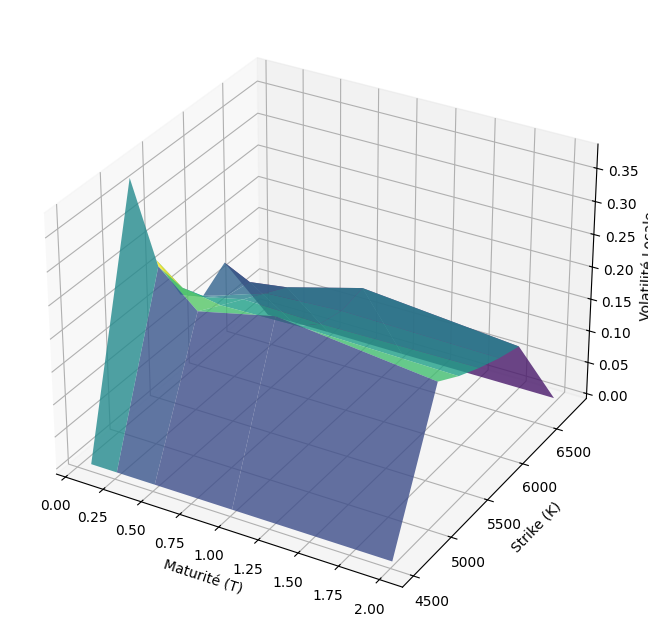

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

T_mesh, K_mesh = np.meshgrid(T_grid, K_grid)
surf = ax.plot_surface(T_mesh, K_mesh, local_vol_grid.T, cmap='viridis', alpha=0.8)

ax.set_xlabel('Maturité (T)')
ax.set_ylabel('Strike (K)')
ax.set_zlabel('Volatilité Locale')
plt.show()


EXEMPLE PRATIQUE COMPLET


In [43]:
# Paramètres EuroStoxx 50
spot = 3800  # prix spot SX5E
T_calc = 0.08  # 1 an
K_calc = 4400  # strike

# Calcul pour un point
local_vol = calculate_dupire_local_vol(
    T=T_calc,
    K=K_calc,
    spot=spot,
    r=0.04,      # taux 1 an
    q=0.02       # dividende
)

print(f"Volatilité locale pour T={T_calc}, K={K_calc}: {local_vol:.1%}")


Volatilité locale pour T=0.08, K=4400: 31.8%


Etude de tendance


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paramètres de base
spot = 4400
r = 0.04
q = 0.02
pas = 100

# Grilles de T et K
T_values = [0.08, 0.25, 0.5, 1, 2]
#K = np.array ((0.8, 0.9, 1.0, 1.1, 1.2 ) )
K_values = np.linspace(3279, 5695, pas)

# Stockage des résultats
data = []

for T in T_values:
    for K in K_values:
        vol = calculate_dupire_local_vol(T=T, K=K, spot=spot, r=r, q=q)
        data.append({'T': T, 'K': K, 'local_vol': vol})

# Création du DataFrame
df = pd.DataFrame(data)



        T            K  local_vol
94   0.08  5572.979798   0.078101
95   0.08  5597.383838   0.076781
96   0.08  5621.787879   0.075630
97   0.08  5646.191919   0.074652
98   0.08  5670.595960   0.073857
99   0.08  5695.000000   0.073246
194  0.25  5572.979798   0.095196
195  0.25  5597.383838   0.094289
196  0.25  5621.787879   0.093463
197  0.25  5646.191919   0.092677
198  0.25  5670.595960   0.092016
199  0.25  5695.000000   0.091416
294  0.50  5572.979798   0.119350
295  0.50  5597.383838   0.118554
296  0.50  5621.787879   0.117745
297  0.50  5646.191919   0.116976
298  0.50  5670.595960   0.116214
299  0.50  5695.000000   0.115399
394  1.00  5572.979798   0.133422
395  1.00  5597.383838   0.132591
396  1.00  5621.787879   0.131712
397  1.00  5646.191919   0.131047
398  1.00  5670.595960   0.130509
399  1.00  5695.000000   0.129984
494  2.00  5572.979798   0.139209
495  2.00  5597.383838   0.138380
496  2.00  5621.787879   0.137278
497  2.00  5646.191919   0.136197
498  2.00  567

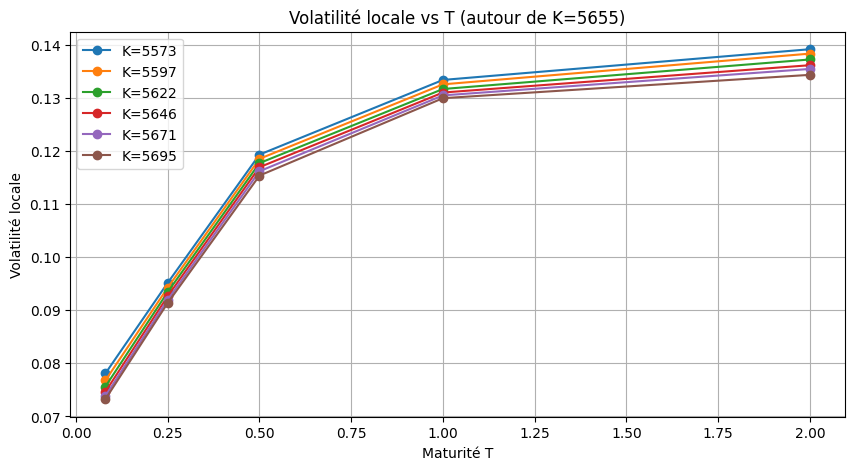

In [58]:
# Plot 1 : Volatilité locale en fonction de T pour un K fixe - Low point pendant 5ans : 3279
K_target = 5655
df_T = df[np.abs(df['K'] - K_target) < pas]  # tolérance autour de K_target
print (df_T )
plt.figure(figsize=(10, 5))
for k in sorted(df_T['K'].unique()):
    subset = df_T[df_T['K'] == k]
    plt.plot(subset['T'], subset['local_vol'], marker='o', label=f'K={k:.0f}')
plt.title(f"Volatilité locale vs T (autour de K={K_target})")
plt.xlabel("Maturité T")
plt.ylabel("Volatilité locale")
plt.legend()
plt.grid(True)
plt.show()

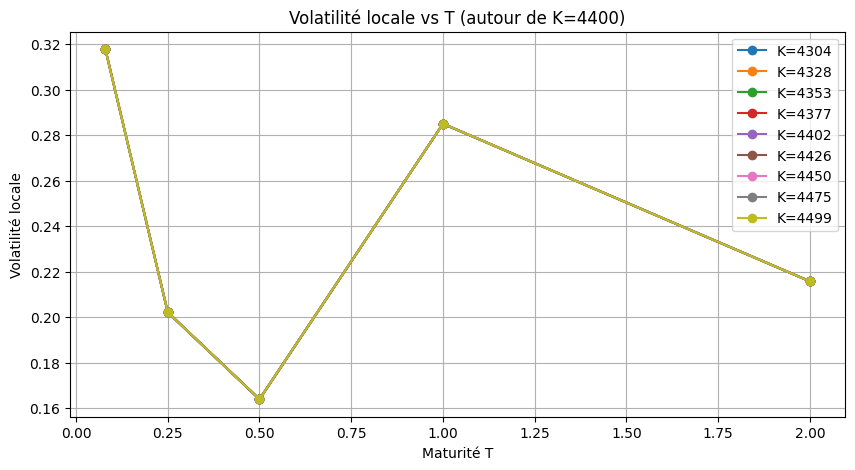

In [46]:
# Plot 1.2 : Volatilité locale en fonction de T pour un K fixe - average point pendant 5ans : 4400
K_target = 4400
df_T = df[np.abs(df['K'] - K_target) < pas ]  # tolérance autour de K_target

plt.figure(figsize=(10, 5))
for k in sorted(df_T['K'].unique()):
    subset = df_T[df_T['K'] == k]
    plt.plot(subset['T'], subset['local_vol'], marker='o', label=f'K={k:.0f}')
plt.title(f"Volatilité locale vs T (autour de K={K_target})")
plt.xlabel("Maturité T")
plt.ylabel("Volatilité locale")
plt.legend()
plt.grid(True)
plt.show()


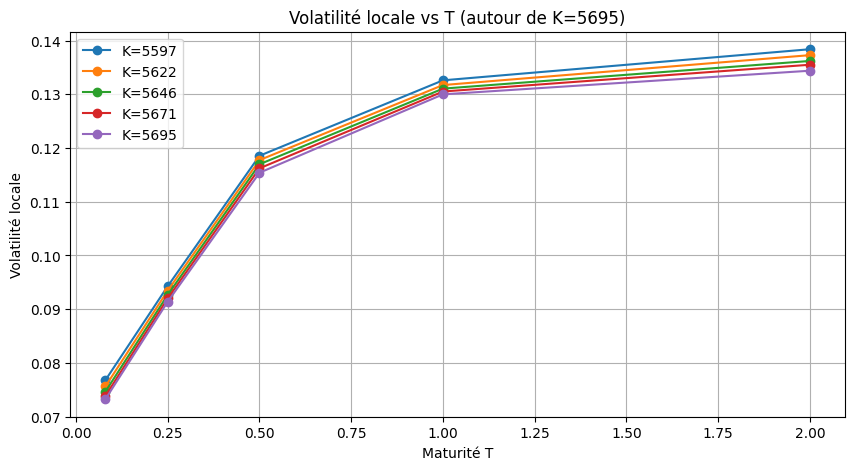

In [47]:
# Plot 1.3 : Volatilité locale en fonction de T pour un K fixe - average point pendant 5ans : 5695
K_target = 5695
df_T = df[np.abs(df['K'] - K_target) < pas]  # tolérance autour de K_target

plt.figure(figsize=(10, 5))
for k in sorted(df_T['K'].unique()):
    subset = df_T[df_T['K'] == k]
    plt.plot(subset['T'], subset['local_vol'], marker='o', label=f'K={k:.0f}')
plt.title(f"Volatilité locale vs T (autour de K={K_target})")
plt.xlabel("Maturité T")
plt.ylabel("Volatilité locale")
plt.legend()
plt.grid(True)
plt.show()


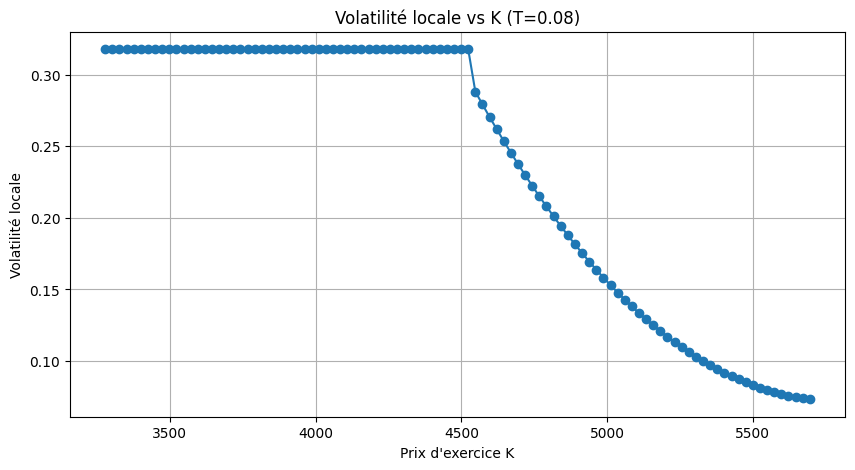

In [48]:
# 📈 Plot 2 : Volatilité locale en fonction de K pour un T fixe monthly
T_target = 0.08
df_K = df[df['T'] == T_target]

plt.figure(figsize=(10, 5))
plt.plot(df_K['K'], df_K['local_vol'], marker='o')
plt.title(f"Volatilité locale vs K (T={T_target})")
plt.xlabel("Prix d'exercice K")
plt.ylabel("Volatilité locale")
plt.grid(True)
plt.show()

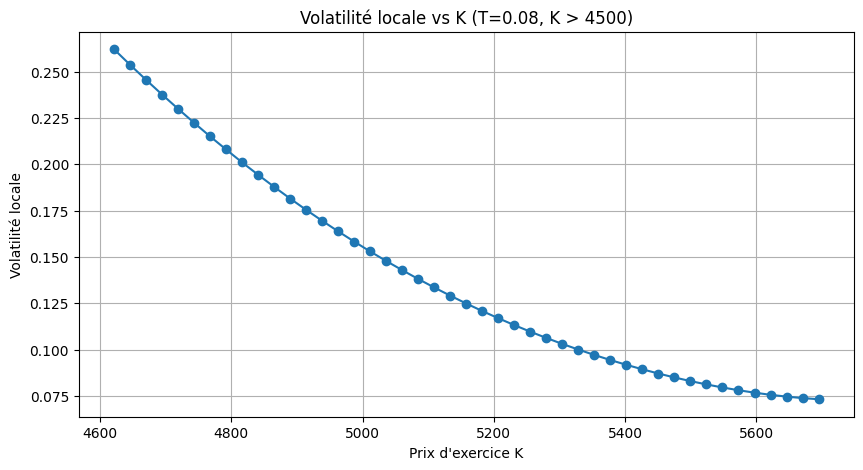

In [49]:
T_target = 0.08
df_K = df[(df['T'] == T_target) & (df['K'] > 4600)]

plt.figure(figsize=(10, 5))
plt.plot(df_K['K'], df_K['local_vol'], marker='o')
plt.title(f"Volatilité locale vs K (T={T_target}, K > 4500)")
plt.xlabel("Prix d'exercice K")
plt.ylabel("Volatilité locale")
plt.grid(True)
plt.show()

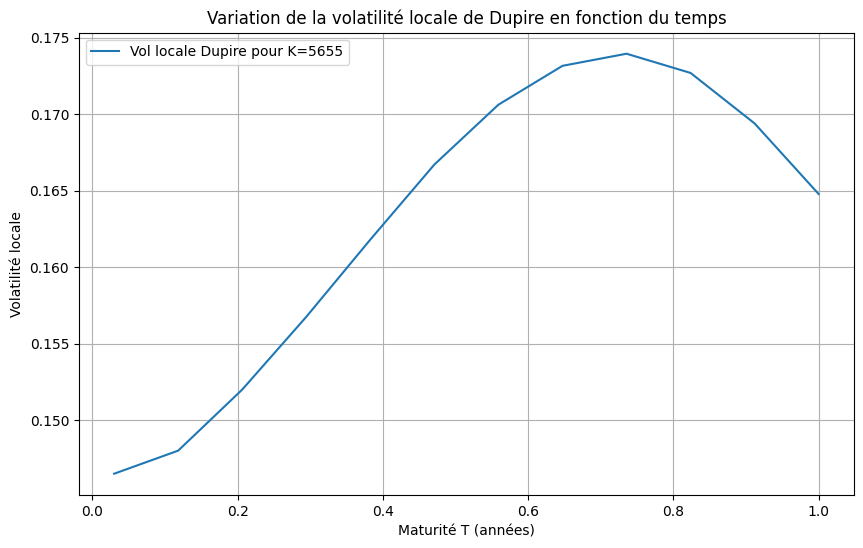

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
spot = 5655
K_calc = 5655
r = 0.01921
q = 0.02

# Grille de maturités
T_values = np.linspace(0.03, 1.0, 12)
local_vols = []

# Boucle sur les maturités
for T in T_values:
    try:
        vol = calculate_dupire_local_vol(T=T, K=K_calc, spot=spot, r=r, q=q)
        local_vols.append(vol)
    except Exception as e:
        local_vols.append(np.nan)  # En cas d'erreur, on insère NaN

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(T_values, local_vols, label=f"Vol locale Dupire pour K={K_calc}")
plt.xlabel("Maturité T (années)")
plt.ylabel("Volatilité locale")
plt.title("Variation de la volatilité locale de Dupire en fonction du temps")
plt.grid(True)
plt.legend()
plt.show()

[T=0.08, K=4524.0] ⚠️ Variance locale négative ou nulle : -4.322088592369994e-07
[T=0.08, K=6786.0] ⚠️ Variance locale négative ou nulle : -9.561330206652321e-08


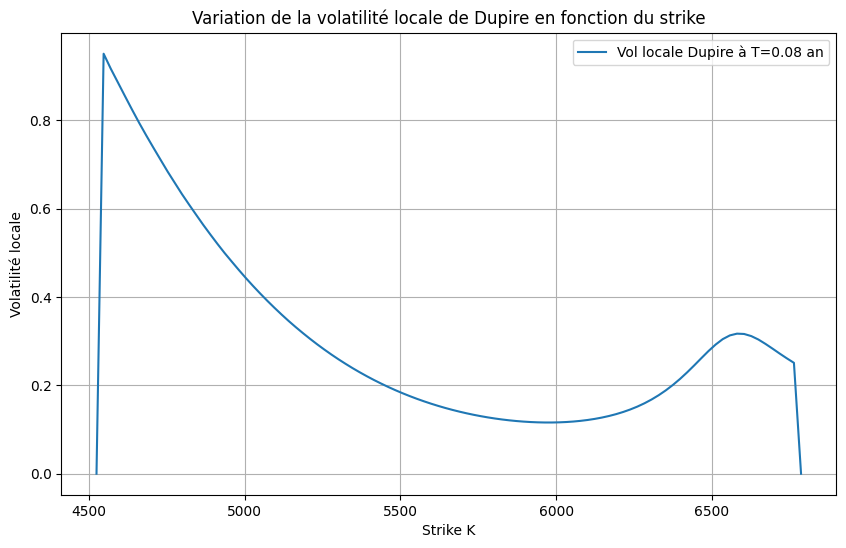

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
spot = 5655
T_fixed = 0.08  # Maturité fixe (en années)
r = 0.04
q = 0.02

# Grille de strikes autour du spot
K_values = np.linspace(0.8 * spot, 1.2 * spot, 100)
local_vols = []

# Boucle sur les strikes
for K in K_values:
    try:
        vol = calculate_dupire_local_vol(T=T_fixed, K=K, spot=spot, r=r, q=q)
        local_vols.append(vol)
    except Exception as e:
        local_vols.append(np.nan)  # En cas d'erreur, on insère NaN

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(K_values, local_vols, label=f"Vol locale Dupire à T={T_fixed:.2f} an")
plt.xlabel("Strike K")
plt.ylabel("Volatilité locale")
plt.title("Variation de la volatilité locale de Dupire en fonction du strike")
plt.grid(True)
plt.legend()
plt.show()

# Scénario 2 - Simulation Dupire daily


'Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50' (%):
          80%   90%   95%  100%  105%  110%  120%
0.00 an  88.9  59.0  36.8  17.0  23.5  37.1  53.3
0.08 an  36.2  24.0  18.7  14.4  12.1  13.2  20.4
0.25 an  27.8  21.0  18.1  15.6  13.9  13.1  13.8
0.50 an  24.9  20.0  17.7  15.9  14.6  13.8  13.2
1.00 an  22.9  19.5  18.0  16.7  16.1  15.7  14.9


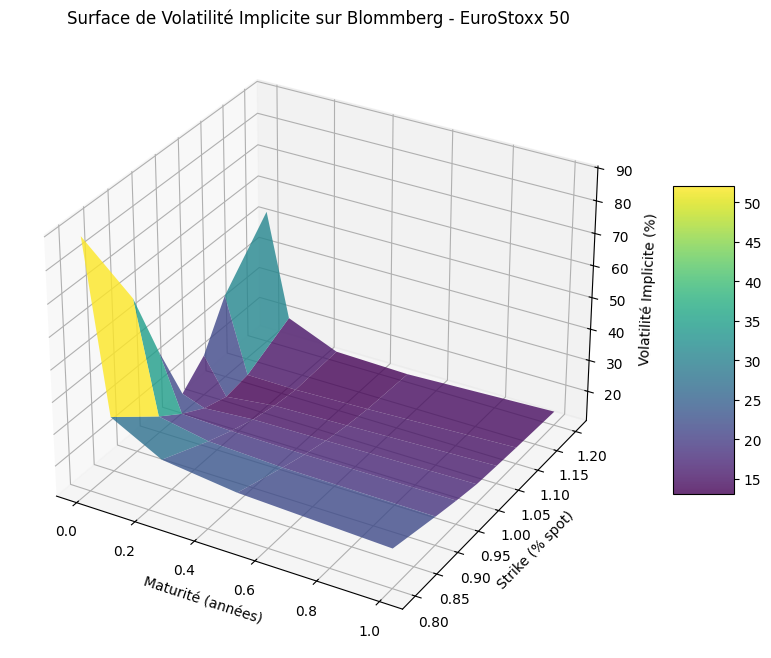

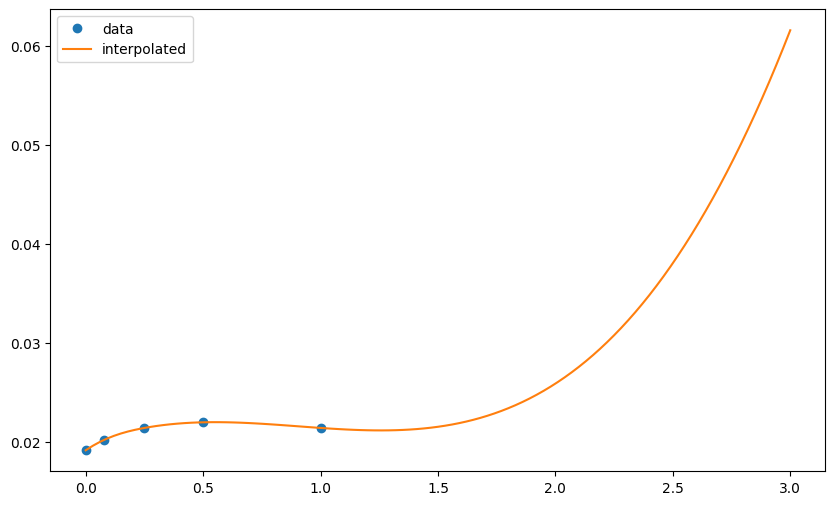

In [52]:
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
# ************ 1. collecte des données   ***************************
T = np.array ( [0.003, 0.08, 0.25, 0.5, 1.0 ] )  # Maturité en année
K = np.array (( 0.8,   0.9,  0.95, 1.0, 1.05, 1.1, 1.2 ) )     # spot price

# from mpl_toolkits.mplot3d import Axes3D

spot_price = 5655     # Prix spot fictif de l'EuroStoxx 50

# Grille de maturités (en années)
maturities = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ])
#maturities = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ] )

# Grille de strikes (en % du spot)
strike_ratios = np.array([0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2])
strikes = strike_ratios * spot_price

# Surface de volatilité implicite fictive (en %) # Dimensions: 5 maturités × 7 strikes
iv_matrix = np.array([
    # 80%    90%    95%    100%    105%    110%    120%  (strike ratios)
    [88.94, 59.04, 36.85,  16.97,  23.49,  37.12,  53.28],  # 1 day (0.003 an)   07/11/2027
    [36.19, 24.03, 18.72,  14.41,  12.07,  13.24,  20.37],  # 1 mois (0.08 an) 5/12/2025
    [27.79, 21.00, 18.06,  15.58,  13.92,  13.08,  13.76],  # 3 mois (0.25 an) 20/02/2026
    [24.91, 19.95, 17.74,  15.91,  14.60,  13.79,  13.15],  # 6 mois (0.5 an)  15/05/2026
    [22.91, 19.52, 17.98,  16.68,  16.13,  15.66,  14.89],  # 1 an (1.0 an)    20/11/2026

])

# Création d'un DataFrame pour une meilleure visualisation
iv_df = pd.DataFrame(
    iv_matrix,
    index=[f'{m:.2f} an' for m in maturities],
    columns=[f'{ratio:.0%}' for ratio in strike_ratios]
)

print("'Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50' (%):")
print(iv_df.round(1))
# IV_surface = interpolate.rectBivaruateSoline(T,K,IV,kx=3,ky=3,s=0.1)
# IV_surface = iv_df
# print(IV_surface.round(1))

# Création de la grille
T_mesh, K_mesh = np.meshgrid(maturities, strike_ratios)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface 3D
surf = ax.plot_surface(T_mesh, K_mesh, iv_matrix.T, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)

ax.set_xlabel('Maturité (années)')
ax.set_ylabel('Strike (% spot)')
ax.set_zlabel('Volatilité Implicite (%)')
ax.set_title('Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50')

plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

from scipy import interpolate

# Taux sans risque r(T):
rates_dates = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ])

rates_values = np.array([0.01921, 0.02023, 0.02142, 0.02199, 0.02142])  # taux
rate_curve = interpolate.interp1d(rates_dates, rates_values,kind='cubic', fill_value='extrapolate')
r = rate_curve(T)

# Taux de dividende q(T):
# Méthode 1: Dividendes implicites depuis les forwards
# Méthode 2: Dividendes explicites actualisés q = 0.02

dividend_dates = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ])

dividend_values = np.array([0.02, 0.02, 0.02, 0.02, 0.02])  # taux
dividend_curve = interpolate.interp1d(rates_dates, rates_values, kind='cubic', fill_value='extrapolate')

q = dividend_curve(T)

# plot zc curve interpolated
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
maturities = np.linspace(0, 3, num=101, endpoint=True)
plt.plot(rates_dates, rates_values, 'o', maturities, rate_curve(maturities))
plt.legend(['data', 'interpolated'], loc='best')
plt.show()

In [53]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! version fonction just pour test !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def calculate_dupire_local_vol(T, K, spot, r, q):
    # 1. Volatilité implicite et ses dérivées
    iv = iv_surface(T, K)[0][0]
    if iv == 0:
        print(f"[T={T}, K={K}] ⚠️ Volatilité implicite nulle")

    # Dérivée par rapport au temps
    dT = 0.001
    iv_T_plus = iv_surface(T + dT, K)[0][0]
    dIV_dT = (iv_T_plus - iv) / dT

    # Dérivée première par rapport à K
    dK = 0.01 * spot
    iv_K_plus = iv_surface(T, K + dK)[0][0]
    iv_K_minus = iv_surface(T, K - dK)[0][0]
    dIV_dK = (iv_K_plus - iv_K_minus) / (2 * dK)

    # Dérivée seconde par rapport à K
    d2IV_dK2 = (iv_K_plus - 2 * iv + iv_K_minus) / (dK ** 2)

    # 2. Calcul de d+
    try:
        d_plus = (np.log(spot / K) + (r - q + 0.5 * iv ** 2) * T) / (iv * np.sqrt(T))
    except ZeroDivisionError:
        print(f"[T={T}, K={K}] ⚠️ Division par zéro dans d_plus")
        return 0

    # 3. Application formule Dupire
    numerator = 2 * dIV_dT + iv / T + 2 * K * (r - q) * dIV_dK
    denominator_term1 = d2IV_dK2
    print(f"[T={T}, K={K}]")
    print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
    denominator_term2 = -d_plus * np.sqrt(T) * (dIV_dK) ** 2
    denominator_term3 = (1 / iv) * (1 / (K * np.sqrt(T)) + d_plus * dIV_dK) ** 2

    denominator = K ** 2 * (denominator_term1 + denominator_term2 + denominator_term3)
#--------------------------------------------------------------------------------------------------------------------------------------
#    if denominator == 0:
#       print(f"[T={T}, K={K}] ⚠️ Dénominateur exactement nul dans la formule de Dupire")
#        return 0
#    elif denominator < 0:
#        print(f"[T={T}, K={K}] ⚠️ Dénominateur négatif dans la formule de Dupire : {denominator}")
#        return 0


    if denominator == 0:
        print(f"[T={T}, K={K}] ⚠️ Dénominateur exactement nul dans la formule de Dupire")
        print(f"  ➤ Termes du dénominateur :")
        print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
        print(f"     - Term2 (-d⁺√T·(dIV/dK)²) = {denominator_term2}")
        print(f"     - Term3 (1/IV · ...)     = {denominator_term3}")
        return 0
    elif denominator < 0:
         print(f"[T={T}, K={K}] ⚠️ Dénominateur négatif dans la formule de Dupire : {denominator}")
         print(f"  ➤ Termes du dénominateur :")
         print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
         print(f"     - Term2 (-d⁺√T·(dIV/dK)²) = {denominator_term2}")
         print(f"     - Term3 (1/IV · ...)     = {denominator_term3}")
         return 0

# -------------------------------------------------------------------------------------------------------------------------------------------
    local_var = numerator / denominator
    if local_var <= 0:
        print(f"[T={T}, K={K}] ⚠️ Variance locale négative ou nulle : {local_var}")
        return 0

    return np.sqrt(local_var)
# -------------------------------------------------------------------------------------------------------------------------------------------

# !!!!!!!!!! Grille de calcul: !!!!!!!!!!!!!!!!!  version détecter vol locale = 0  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
T_grid = T_array
K_grid = K_array

local_vol_grid = np.zeros((len(T_grid), len(K_grid)))

for i, T_val in enumerate(T_grid):
    for j, K_val in enumerate(K_grid):
        r_val = rate_curve(T_val)
        q_val = dividend_curve(T_val)  # si disponible

        # calculate_dupire_local_vol( T_val, K_val, spot_price, r_val, q_val)

        vol = calculate_dupire_local_vol(T_val, K_val, spot_price, r_val, q_val)

        if vol == 0:
            print(f"⚠️ Alerte : Volatilité locale nulle détectée pour T={T_val}, K={K_val} — valeur ignorée.")
            continue  # saute cette itération

        local_vol_grid[i, j] = vol

print("\nGrille de volatilité locale :")
for i, T_val in enumerate(T_grid):
    for j, K_val in enumerate(K_grid):
        vol = local_vol_grid[i, j]
        print(f"Vol[T={T_val:.4f}, K={K_val:.2f}] = {vol:.6f}")

print(local_vol_grid)



[T=0.08, K=4524.0]
     - Term1 (d²IV/dK²)       = -3.975745941189052e-06
[T=0.08, K=4524.0] ⚠️ Dénominateur négatif dans la formule de Dupire : -65.58721894179162
  ➤ Termes du dénominateur :
     - Term1 (d²IV/dK²)       = -3.975745941189052e-06
     - Term2 (-d⁺√T·(dIV/dK)²) = -8.089060198327058e-09
     - Term3 (1/IV · ...)     = 7.792335603944352e-07
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.08, K=4524.0 — valeur ignorée.
[T=0.08, K=5089.5]
     - Term1 (d²IV/dK²)       = 1.0506410652788678e-07
[T=0.08, K=5372.25]
     - Term1 (d²IV/dK²)       = 1.5363374767687273e-07
[T=0.08, K=5655.0]
     - Term1 (d²IV/dK²)       = 2.022033888259194e-07
[T=0.08, K=5937.75]
     - Term1 (d²IV/dK²)       = 2.50773029974914e-07
[T=0.08, K=6220.500000000001]
     - Term1 (d²IV/dK²)       = 2.99342671123939e-07
[T=0.08, K=6786.0]
     - Term1 (d²IV/dK²)       = -3.910186223021605e-06
[T=0.08, K=6786.0] ⚠️ Dénominateur négatif dans la formule de Dupire : -173.1875093065644
  ➤ Termes du d

In [54]:
# Paramètres EuroStoxx 50
spot = 5655  # prix spot SX5E
T_calc = 0.08  # 1 an
K_calc = 5655  # strike

# Calcul pour un point
local_vol = calculate_dupire_local_vol(
    T=T_calc,
    K=K_calc,
    spot=spot,
    r=0.01921,      # taux 1 an
    q=0.02       # dividende
)

print(f"Volatilité locale pour T={T_calc}, K={K_calc}: {local_vol:.1%}")

[T=0.08, K=5655]
     - Term1 (d²IV/dK²)       = 2.022033888259194e-07
Volatilité locale pour T=0.08, K=5655: 14.7%


[T=0.03, K=5655]
     - Term1 (d²IV/dK²)       = 2.022033888259194e-07
[T=0.11818181818181818, K=5655]
     - Term1 (d²IV/dK²)       = 1.7663503013343725e-07
[T=0.20636363636363636, K=5655]
     - Term1 (d²IV/dK²)       = 1.2597329333746459e-07
[T=0.29454545454545455, K=5655]
     - Term1 (d²IV/dK²)       = 8.618375773403923e-08
[T=0.3827272727272727, K=5655]
     - Term1 (d²IV/dK²)       = 5.6235368107060907e-08
[T=0.47090909090909094, K=5655]
     - Term1 (d²IV/dK²)       = 3.5097069240585586e-08
[T=0.5590909090909091, K=5655]
     - Term1 (d²IV/dK²)       = 2.173780591868661e-08
[T=0.6472727272727273, K=5655]
     - Term1 (d²IV/dK²)       = 1.512652292528108e-08
[T=0.7354545454545455, K=5655]
     - Term1 (d²IV/dK²)       = 1.4232165044398927e-08
[T=0.8236363636363636, K=5655]
     - Term1 (d²IV/dK²)       = 1.8023677060035375e-08
[T=0.9118181818181819, K=5655]
     - Term1 (d²IV/dK²)       = 2.5470003756263752e-08
[T=1.0, K=5655]
     - Term1 (d²IV/dK²)       = 3.5540089916992487e-

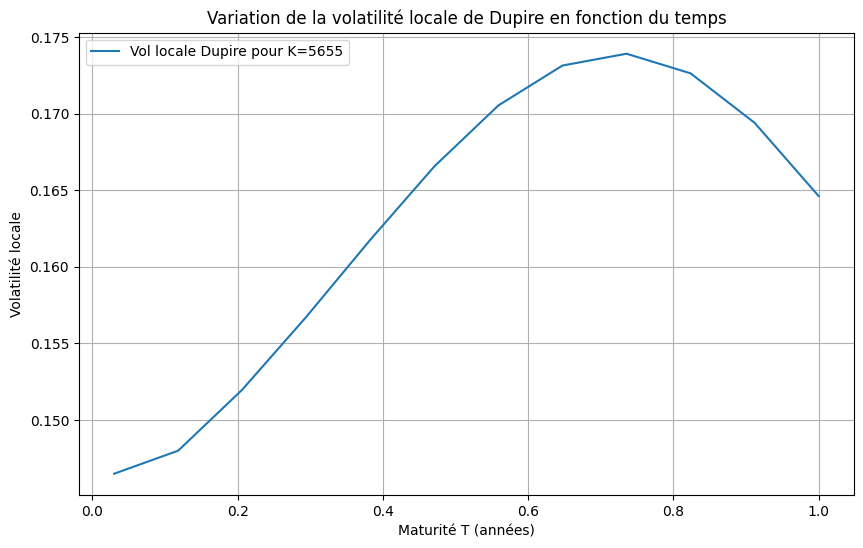

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
spot = 5655
K_calc = 5655
r = 0.01921
q = 0.02

# Grille de maturités
T_values = np.linspace(0.03, 1.0, 12)
local_vols = []

# Boucle sur les maturités
for T in T_values:
    try:
        vol = calculate_dupire_local_vol(T=T, K=K_calc, spot=spot, r=r, q=q)
        local_vols.append(vol)
    except Exception as e:
        local_vols.append(np.nan)  # En cas d'erreur, on insère NaN

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(T_values, local_vols, label=f"Vol locale Dupire pour K={K_calc}")
plt.xlabel("Maturité T (années)")
plt.ylabel("Volatilité locale")
plt.title("Variation de la volatilité locale de Dupire en fonction du temps")
plt.grid(True)
plt.legend()
plt.show()

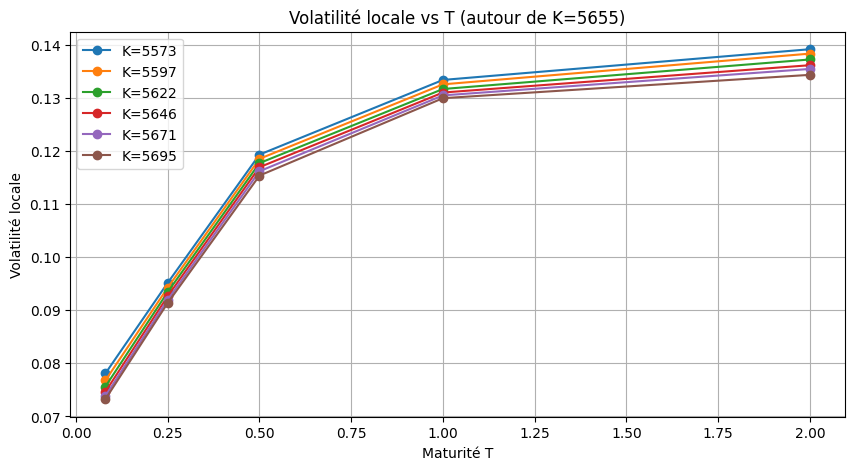

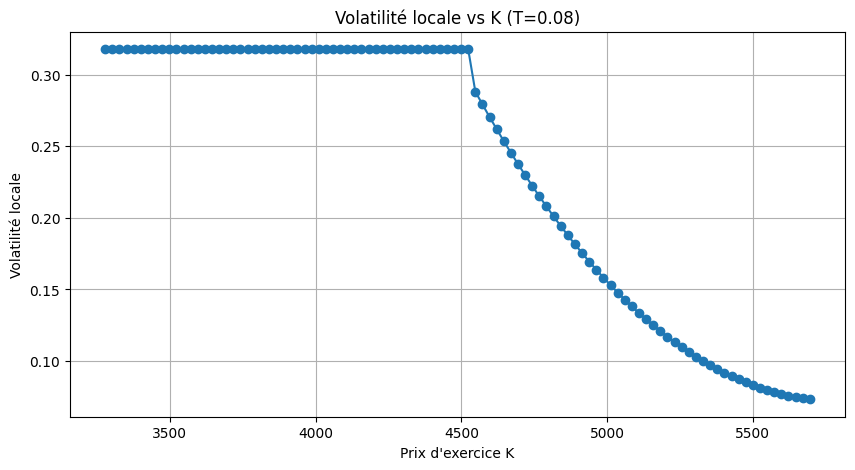

In [56]:
# Plot 1 : Volatilité locale en fonction de T pour un K fixe - Low point pendant 5ans : 3279
K_target = 5655
df_T = df[np.abs(df['K'] - K_target) < pas]  # tolérance autour de K_target

plt.figure(figsize=(10, 5))
for k in sorted(df_T['K'].unique()):
    subset = df_T[df_T['K'] == k]
    plt.plot(subset['T'], subset['local_vol'], marker='o', label=f'K={k:.0f}')
plt.title(f"Volatilité locale vs T (autour de K={K_target})")
plt.xlabel("Maturité T")
plt.ylabel("Volatilité locale")
plt.legend()
plt.grid(True)
plt.show()

#___________________________________________________________________

# 📈 Plot 2 : Volatilité locale en fonction de K pour un T fixe monthly
T_target = 0.08
df_K = df[df['T'] == T_target]

plt.figure(figsize=(10, 5))
plt.plot(df_K['K'], df_K['local_vol'], marker='o')
plt.title(f"Volatilité locale vs K (T={T_target})")
plt.xlabel("Prix d'exercice K")
plt.ylabel("Volatilité locale")
plt.grid(True)
plt.show()

[T=0.08, K=4524.0]
     - Term1 (d²IV/dK²)       = -3.975745941189052e-06
[T=0.08, K=4524.0] ⚠️ Dénominateur négatif dans la formule de Dupire : -65.58290965984295
  ➤ Termes du dénominateur :
     - Term1 (d²IV/dK²)       = -3.975745941189052e-06
     - Term2 (-d⁺√T·(dIV/dK)²) = -8.086820212742245e-09
     - Term3 (1/IV · ...)     = 7.794418725768663e-07
[T=0.08, K=4546.848484848485]
     - Term1 (d²IV/dK²)       = -2.3619252271567353e-06
[T=0.08, K=4546.848484848485] ⚠️ Dénominateur négatif dans la formule de Dupire : -38.59134257655536
  ➤ Termes du dénominateur :
     - Term1 (d²IV/dK²)       = -2.3619252271567353e-06
     - Term2 (-d⁺√T·(dIV/dK)²) = -1.578236333951297e-08
     - Term3 (1/IV · ...)     = 5.110316798999666e-07
[T=0.08, K=4569.69696969697]
     - Term1 (d²IV/dK²)       = -7.484531657902889e-07
[T=0.08, K=4569.69696969697] ⚠️ Dénominateur négatif dans la formule de Dupire : -9.901099913518916
  ➤ Termes du dénominateur :
     - Term1 (d²IV/dK²)       = -7.484531657902

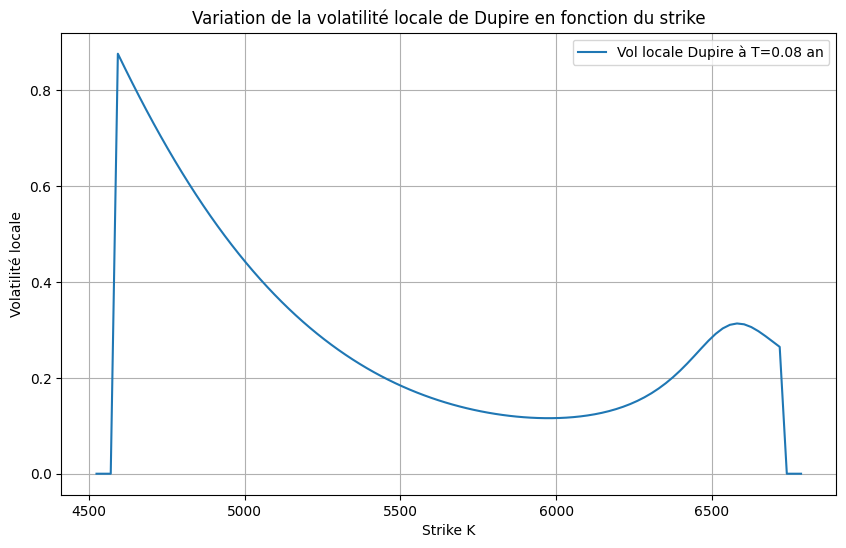

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
spot = 5655
T_fixed = 0.08  # Maturité fixe (en années)
r = 0.01921
q = 0.02

# Grille de strikes autour du spot
K_values = np.linspace(0.8 * spot, 1.2 * spot, 100)
local_vols = []

# Boucle sur les strikes
for K in K_values:
    try:
        vol = calculate_dupire_local_vol(T=T_fixed, K=K, spot=spot, r=r, q=q)
        local_vols.append(vol)
    except Exception as e:
        local_vols.append(np.nan)  # En cas d'erreur, on insère NaN

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(K_values, local_vols, label=f"Vol locale Dupire à T={T_fixed:.2f} an")
plt.xlabel("Strike K")
plt.ylabel("Volatilité locale")
plt.title("Variation de la volatilité locale de Dupire en fonction du strike")
plt.grid(True)
plt.legend()
plt.show()